In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import random
from torch.utils.data import Dataset, DataLoader

SEED = 12345
torch.random.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ---------------------------------------------------------------------------------------
"Global variables for specific dataset information loading."

MIMIC_PARSE_TIME_VARS = ["intime", "outtime", "chartmax"]
MIMIC_PARSE_TD_VARS = ["sampled_time_to_end(1H)", "time_to_end", "time_to_end_min", "time_to_end_max"]
MIMIC_VITALS = ["TEMP", "HR", "RR", "SPO2", "SBP", "DBP"]
MIMIC_STATIC = ["age", "gender", "ESI"]
MIMIC_OUTCOME_NAMES = ["De" ,"I", "W", "Di"]

MAIN_ID_LIST = ["subject_id", "hadm_id", "stay_id", "patient_id", "pat_id"]  # Identifiers for main ids.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def convert_to_timedelta(df: pd.DataFrame, *args) -> pd.DataFrame:
    """Convert all given cols of dataframe to timedelta."""
    output = df.copy()
    for arg in args:
        output[arg] = pd.to_timedelta(df.loc[:, arg])

    return output

In [6]:
class CustomDataset(Dataset):


    def __init__(self, data_name="MIMIC", target_window=12, feat_set='vit-sta', time_range=(0, 10), parameters=None):
        if parameters is None:
            self.data_name = data_name
            self.target_window = target_window
            self.feat_set = feat_set
            self.time_range = time_range
            self.id_col = None
            self.time_col = None
            self.needs_time_to_end_computation = False
            self.min = None
            self.max = None

            # Load and process data
            self.id_col, self.time_col, self.needs_time_to_end_computation = self.get_ids(self.data_name)
            self.x, self.y, self.mask, self.pat_time_ids, self.features, self.outcomes, self.x_subset, self.y_data = self.load_transform()
        else:
            self.x, self.y, self.mask, self.pat_time_ids, self.features, self.outcomes, self.x_subset, self.y_data, self.id_col, self.time_col, self.needs_time_to_end_computation, self.data_name, self.feat_set, self.time_range, self.target_window, self.min, self.max = parameters

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        # Extract data for given index
        x = self.x[idx, :, :]
        y = self.y[idx, :]
        mask = self.mask[idx, :, :]
        pat_time_ids = self.pat_time_ids[idx, :, :]
        features = self.features
        outcomes = self.outcomes
        x_subset = self.x_subset[idx, :]
        y_data = self.y_data[idx, :]
        id_col = self.id_col
        time_col = self.time_col
        needs_time_to_end_computation = self.needs_time_to_end_computation
        data_name = self.data_name
        feat_set = self.feat_set
        time_range = self.time_range
        target_window = self.target_window
        min = self.min
        max = self.max
        return x, y, mask, pat_time_ids, features, outcomes, x_subset, y_data, id_col, time_col, needs_time_to_end_computation, data_name, feat_set, time_range, target_window, min, max

    def get_subset(self, idx):
        return CustomDataset(parameters=self[idx])

    def load_transform(self):
        """Load dataset and transform to input format"""

        # Load data
        data = self._load(self.data_name, window=self.target_window)

        # Get data info
        self.id_col, self.time_col, self.needs_time_to_end_computation = self.get_ids(self.data_name)

        # Add time to end and truncate if needed
        # print(data[0].shape, '0')
        x_inter = self._add_time_to_end(data[0])
        # print(x_inter.shape, '1')
        x_inter = self._truncate(x_inter)
        # print(x_inter.shape, '2')
        self._check_correct_time_conversion(x_inter)

        # Subset to relevant features (keeps self.id_col and self.time_col still)
        # print(x_inter.shape, '3')
        x_subset, features = self.subset_to_features(x_inter)

        # Convert to 3D array
        # print(x_inter.shape, '4')
        x_inter, pat_time_ids = self.convert_to_3darray(x_subset)
        x_subset = x_subset.to_numpy().astype(np.float32)

        # Normalise array
        # print(x_inter.shape, '5')
        x_inter = self.normalise(x_inter)

        # Impute missing values
        # print(x_inter.shape, '6')
        x_out, mask = self.impute(x_inter)
        # print(x_out.shape, '7')

        # Do things to y
        outcomes = self._get_outcome_names(self.data_name)
        y_data = data[1][outcomes]
        y_out = y_data.to_numpy().astype("float32")
        y_data = y_data.to_numpy().astype("float32")

        # Check data loaded correctly
        self._check_input_format(x_out, y_out)

        return x_out, y_out, mask, pat_time_ids, features, outcomes, x_subset, y_data
    



    def _load(self, data_name, window=4):
        """Load Trajectory, Target data jointly given data folder."""

        # Make data folder
        data_fd = f"data/{data_name}/processed/"
        try:
            os.path.exists(data_fd)
        except AssertionError:
            print(data_fd)


        if "MIMIC" in data_name:

            # Load Data
            X = pd.read_csv(data_fd + "vitals_process.csv", parse_dates=MIMIC_PARSE_TIME_VARS, header=0, index_col=0)
            y = pd.read_csv(data_fd + f"outcomes_{window}h_process.csv", index_col=0)
            # for Kaggle:
#             X = pd.read_csv("vitals_process.csv", parse_dates=MIMIC_PARSE_TIME_VARS, header=0, index_col=0)
#             y = pd.read_csv(f"outcomes_{window}h_process.csv", index_col=0)

            # Convert columns to timedelta
            X = convert_to_timedelta(X, *MIMIC_PARSE_TD_VARS)

        elif "SAMPLE" in data_name:

            # Load data
            X = None
            y = None

        else:
            raise ValueError(f"Data Name does not match available datasets. Input Folder provided {data_fd}")
        return X, y
    
    def get_ids(self, data_name):
            """
            Get input id information.

            Params:
            - data_folder: str, folder of dataset, or name of dataset.

            Returns:
                - Tuple of id col, time col and whether time to end needs computation.
            """

            if "MIMIC" in data_name:
                id_col, time_col, needs_time_to_end = "hadm_id", "sampled_time_to_end(1H)", False

            elif "SAMPLE" in data_name:
                id_col, time_col, needs_time_to_end = None, None, None

            else:
                raise ValueError(f"Data Name does not match available datasets. Input Folder provided {data_name}")

            return id_col, time_col, needs_time_to_end
        
    def impute(self, X):
            """
            Imputation of 3D array accordingly with time as dimension 1:
            1st - forward value propagation,
            2nd - backwards value propagation,
            3rd - median value imputation.

            Mask returned at the end, corresponding to original missing values.
            """
            impute_step1 = self._numpy_forward_fill(X)
            impute_step2 = self._numpy_backward_fill(impute_step1)
            impute_step3 = self._median_fill(impute_step2)

            # Compute mask
            mask = np.isnan(X)

            return impute_step3, mask
    
    def convert_datetime_to_hour(self, series):
        """Convert pandas Series of datetime values to float Series with corresponding hour values"""
        seconds_per_hour = 3600

        return series.dt.total_seconds() / seconds_per_hour


    def _get_features(self, key, data_name="MIMIC"):
        """
        Compute list of features to keep given key. Key can be one of:
        - str, where the corresponding features are selected according to the fn below.
        - list, where the corresponding features are the original list.
        """
        if isinstance(key, list):
            return key

        elif isinstance(key, str):
            if data_name == "MIMIC":
                vitals = MIMIC_VITALS
                static = MIMIC_STATIC
                vars1, vars2 = None, None

            elif data_name == "SAMPLE":
                vitals, vars1, vars2, static = None, None, None, None

            else:
                raise ValueError(f"Data Name does not match available datasets. Input provided {data_name}")

            # Add features given substrings of key. We initialise set in case of repetition (e.g. 'vars1-lab')
            features = set([])
            if "vit" in key.lower():
                features.update(vitals)

            if "vars1" in key.lower():
                features.update(vars1)

            if "vars2" in key.lower():
                features.update(vars2)

            if "lab" in key.lower():
                features.update(vars1)
                features.update(vars2)

            if "sta" in key.lower():
                features.update(static)

            if "all" in key.lower():
                features = self._get_features("vit-lab-sta", data_name)

            sorted_features = sorted(features)  # sorted returns a list of features.
            print(f"\n{data_name} data has been subsettted to the following features: \n {sorted_features}.")

            return sorted_features

        else:
            raise TypeError(f"Argument key must be one of type str or list, type {type(key)} was given.")


    def _numpy_forward_fill(self, array):
        """Forward Fill a numpy array. Time index is axis = 1."""
        array_mask = np.isnan(array)
        array_out = np.copy(array)

        # Add time indices where not masked, and propagate forward
        inter_array = np.where(~ array_mask, np.arange(array_mask.shape[1]).reshape(1, -1, 1), 0)
        np.maximum.accumulate(inter_array, axis=1,
                            out=inter_array)  # For each (n, t, d) missing value, get the previously accessible mask value

        # Index matching for output. For n, d sample as previously, use inter_array for previous time id
        array_out = array_out[np.arange(array_out.shape[0])[:, None, None],
                            inter_array,
                            np.arange(array_out.shape[-1])[None, None, :]]

        return array_out


    def _numpy_backward_fill(self, array):
        """Backward Fill a numpy array. Time index is axis = 1"""
        array_mask = np.isnan(array)
        array_out = np.copy(array)

        # Add time indices where not masked, and propagate backward
        inter_array = np.where(~ array_mask, np.arange(array_mask.shape[1]).reshape(1, -1, 1), array_mask.shape[1] - 1)
        inter_array = np.minimum.accumulate(inter_array[:, ::-1], axis=1)[:, ::-1]
        array_out = array_out[np.arange(array_out.shape[0])[:, None, None],
                            inter_array,
                            np.arange(array_out.shape[-1])[None, None, :]]

        return array_out


    def _median_fill(self, array):
        """Median fill a numpy array. Time index is axis = 1"""
        array_mask = np.isnan(array)
        array_out = np.copy(array)

        # Compute median and impute
        array_med = np.nanmedian(np.nanmedian(array, axis=0, keepdims=True), axis=1, keepdims=True)
        array_out = np.where(array_mask, array_med, array_out)

        return array_out
    
    def _get_outcome_names(self, data_name):
        """Return the corresponding outcome columns given dataset name."""
        if data_name == "MIMIC":
            return MIMIC_OUTCOME_NAMES

        elif data_name == "SAMPLE":
            return None


    def _check_input_format(self, X, y):
        """Check conditions to confirm model input."""

        try:
            # Length and shape conditions
            # print(X.shape, y.shape)
            cond1 = X.shape[0] == y.shape[0]
            cond2 = len(X.shape) == 3
            cond3 = len(y.shape) == 2

            # Check non-missing values
            cond4 = np.sum(np.isnan(X)) + np.sum(np.isnan(y)) == 0

            # Check y output is one hot encoded
            cond5 = np.all(np.sum(y, axis=1) == 1)

            assert cond1
            assert cond2
            assert cond3
            assert cond4
            assert cond5

        except Exception as e:
            print(e)
            raise AssertionError("One of the check conditions has failed.")


    def _subset_to_balanced(X, y, mask, ids):
        """Subset samples so dataset is more well sampled."""
        class_numbers = np.sum(y, axis=0)
        largest_class, target_num_samples = np.argmax(class_numbers), np.sort(class_numbers)[-2]
        print("\nSubsetting class {} from {} to {} samples.".format(largest_class, class_numbers[largest_class],
                                                                target_num_samples))

        # Select random
        largest_class_ids = np.arange(y.shape[0])[y[:, largest_class] == 1]
        class_ids_samples = np.random.choice(largest_class_ids, size=target_num_samples, replace=False)
        ids_to_remove_ = np.setdiff1d(largest_class_ids, class_ids_samples)

        # Remove relevant ids
        X_out = np.delete(X, ids_to_remove_, axis=0)
        y_out = np.delete(y, ids_to_remove_, axis=0)
        mask_out = np.delete(mask, ids_to_remove_, axis=0)
        ids_out = np.delete(ids, ids_to_remove_, axis=0)

        return X_out, y_out, mask_out, ids_out
        

    def _add_time_to_end(self, X):
        """Add new column to dataframe - this computes time to end of grouped observations, if needed."""
        x_inter = X.copy(deep=True)

        # if time to end has not been computed
        if self.needs_time_to_end_computation is True:

            # Compute datetime values for time until end of group of observations
            times = X.groupby(self.id_col).apply(lambda x: x.loc[:, self.time_col].max() - x.loc[:, self.time_col])

            # add column to dataframe after converting to hourly times.
            x_inter["time_to_end"] = self.convert_datetime_to_hour(times).values

        else:
            x_inter["time_to_end"] = x_inter[self.time_col].values
            x_inter["time_to_end"] = self.convert_datetime_to_hour(x_inter.loc[:, "time_to_end"])

        # Sort data
        self.time_col = "time_to_end"
        x_out = x_inter.sort_values(by=[self.id_col, "time_to_end"], ascending=[True, False])

        return x_out
    
    def _truncate(self, X):
        """Truncate dataset on time to end column according to self.time_range."""
        try:
            min_time, max_time = self.time_range
            # print(self.time_range)
            return X[X['time_to_end'].between(min_time, max_time, inclusive="left")]

        except Exception:
            raise ValueError(f"Could not truncate to {self.time_range} time range successfully")

    def _check_correct_time_conversion(self, X):
        """Check addition and truncation of time index worked accordingly."""

        cond1 = X[self.id_col].is_monotonic
        cond2 = X.groupby(self.id_col).apply(lambda x: x["time_to_end"].is_monotonic_decreasing).all()

        min_time, max_time = self.time_range
        cond3 = X["time_to_end"].between(min_time, max_time, inclusive='left').all()

        assert cond1 is True
        assert cond2 == True
        assert cond3 == True

    def subset_to_features(self, X):
        """Subset only to variables which were selected"""
        features = [self.id_col, "time_to_end"] + self._get_features(self.feat_set, self.data_name)

        return X[features], features

    def convert_to_3darray(self, X):
        """Convert a pandas dataframe to 3D numpy array of shape (num_samples, num_timestamps, num_variables)."""

        # Obtain relevant shape sizes
        max_time_length = X.groupby(self.id_col).count()["time_to_end"].max()
        num_ids = X[self.id_col].nunique()

        # Other basic definitions
        feats = [col for col in X.columns if col not in [self.id_col, "time_to_end"]]
        list_ids = X[self.id_col].unique()

        # Initialise output array and id-time array
        out_array = np.empty(shape=(num_ids, max_time_length, len(feats)))
        out_array[:] = np.nan

        # Make a parallel array indicating id and corresponding time
        id_times_array = np.empty(shape=(num_ids, max_time_length, 2))

        # Set ids in this newly generated array
        id_times_array[:, :, 0] = np.repeat(np.expand_dims(list_ids, axis=-1), repeats=max_time_length, axis=-1)

        # Iterate through ids
        for id_ in tqdm(list_ids):
            # Subset data to where matches respective id
            index_ = np.where(list_ids == id_)[0]
            x_id = X[X[self.id_col] == id_]

            # Compute negative differences instead of keeping the original times.
            x_id_copy = x_id.copy()
            x_id_copy["time_to_end"] = - x_id["time_to_end"].diff().values

            # Update target output array and time information array
            out_array[index_, :x_id_copy.shape[0], :] = x_id_copy[feats].values
            id_times_array[index_, :x_id_copy.shape[0], 1] = x_id["time_to_end"].values

        return out_array.astype("float32"), id_times_array.astype("float32")

    def normalise(self, X):
        """Given 3D array, normalise according to min-max method."""
        self.min = np.nanmin(X, axis=0, keepdims=True)
        self.max = np.nanmax(X, axis=0, keepdims=True)

        return np.divide(X - self.min, self.max - self.min)

    def apply_normalisation(self, X):
        """Apply normalisation with current parameters to another dataset."""
        if self.min is None or self.max is None:
            raise ValueError(f"Attributes min and/or max are not yet computed. Run 'normalise' method instead.")

        else:
            return np.divide(X - self.min, self.max - self.min)
        



# Custom Dataloader
def collate_fn(data):
    x, y, mask, pat_time_ids, features, outcomes, x_subset, y_data, id_col, time_col, needs_time_to_end_computation, data_name, feat_set, time_range, target_window, min, max = zip(*data)
    data_config = {"data_name": data_name, "feat_set": feat_set, "time_range (h)": time_range, "target_window": target_window}
    data_properties = {"feats": features, "id_col": id_col, "time_col": time_col,
                       "norm_min": min, "norm_max": max, "outc_names": outcomes}

    x = torch.tensor(x)
    y = torch.tensor(y)
    x = x.to(device)
    y = y.to(device)
    # mask = torch.tensor(mask)
    # pat_time_ids = torch.tensor(pat_time_ids)
    # x_subset = torch.tensor(x_subset)
    # y_data = torch.tensor(y_data)

    return x, y


def load_data(train_dataset, val_dataset, test_dataset):
    """
    Return a DataLoader instance basing on a Dataset instance, with batch_size specified.
    set shuffle=???
    """

    batch_size=64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_loader, val_loader, test_loader

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch

dataset = CustomDataset()

# Stratified Sampling for train and val
train_idx, test_idx = train_test_split(np.arange(len(dataset)),
                                             test_size=0.4,
                                             random_state=SEED,
                                             shuffle=True,
                                             stratify=np.argmax(dataset.y,axis=-1))

# Subset dataset for train and val
train_val_dataset = dataset.get_subset(train_idx)
test_dataset = dataset.get_subset(test_idx)

train_idx,  val_idx = train_test_split(np.arange(len(train_val_dataset)),
                                             test_size=0.4,
                                             random_state=SEED,
                                             shuffle=True,
                                             stratify=np.argmax(train_val_dataset.y,axis=-1))

train_dataset = train_val_dataset.get_subset(train_idx)
val_dataset = train_val_dataset.get_subset(val_idx)


train_loader, val_loader, test_loader = load_data(train_dataset, val_dataset, test_dataset)


MIMIC data has been subsettted to the following features: 
 ['DBP', 'ESI', 'HR', 'RR', 'SBP', 'SPO2', 'TEMP', 'age', 'gender'].


100%|██████████| 7701/7701 [00:11<00:00, 681.00it/s]


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeatTimeAttention(nn.Module):
    def __init__(self, latent_dim, input_shape):
        super().__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.latent_dim = latent_dim
        T, D_f = input_shape
        # Define Kernel and Bias for Feature Projection
        self.kernel = torch.zeros(
            (1, 1, D_f, self.latent_dim), requires_grad=True).to(self.device)
        nn.init.xavier_uniform_(self.kernel)
        self.bias = torch.zeros(
            (1, 1, D_f, self.latent_dim), requires_grad=True).to(self.device)
        nn.init.uniform_(self.bias)

        # Define Time aggregation weights for averaging over time.
        self.unnorm_beta = torch.zeros((1, T, 1), requires_grad=True)
        nn.init.uniform_(self.unnorm_beta)

    def forward(self, x, latent):
        o_hat, _ = self.generate_latent_approx(x, latent)
        weights = self.calc_weights(self.unnorm_beta)
        # print(o_hat.shape, weights.shape)
        return torch.sum(torch.mul(o_hat.to(self.device), weights.to(self.device)), dim=1)

    def generate_latent_approx(self, x, latent):
        features = torch.mul(x.unsqueeze(-1), self.kernel) + self.bias
        features = F.relu(features)

        # calculate the score
        X_T, X = features, features.transpose(2, 3)
        # print(X_T.shape, X.shape)
        X_T_X_inv = torch.inverse(torch.matmul(X_T, X))
        # print(X_T.shape, latent.unsqueeze(-1).shape)
        X_T_y = torch.matmul(X_T, latent.unsqueeze(-1))

        score_hat = torch.matmul(X_T_X_inv, X_T_y)
        scores = torch.squeeze(score_hat)

        # print(scores.unsqueeze(-1).shape, features.shape)
        o_hat = torch.sum(torch.mul(scores.unsqueeze(-1), features), dim=2)

        return o_hat, scores

    def calc_weights(self, x):
        abs_x = torch.abs(x)
        return abs_x / torch.sum(abs_x, dim=1)


class Encoder(nn.Module):
    def __init__(self, input_shape, attention_hidden_dim, latent_dim, dropout):
        super().__init__()        
        self.lstm1 = nn.LSTM(input_size=input_shape[1], 
                            hidden_size=attention_hidden_dim,
                            num_layers=2, 
                            dropout=dropout, 
                            batch_first=True)
        self.lstm2 = nn.LSTM(input_size=attention_hidden_dim, 
                            hidden_size=latent_dim,
                            num_layers=1,  
                            batch_first=True)
        self.attention = FeatTimeAttention(latent_dim, input_shape)
        
    def forward(self, x):
        latent_rep, _ = self.lstm1(x)
        latent_rep, _ = self.lstm2(latent_rep)
        output = self.attention(x, latent_rep)
        return output


class Identifier(nn.Module):
    def __init__(self, input_dim, mlp_hidden_dim, dropout, output_dim):
        super().__init__()        
        self.fc1 = nn.Linear(input_dim, mlp_hidden_dim)
        self.sigmoid1 = nn.Sigmoid()

        self.fc2 = nn.Linear(mlp_hidden_dim, mlp_hidden_dim)
        self.sigmoid2 = nn.Sigmoid()
        self.dropout1 = nn.Dropout(dropout)

        self.fc4 = nn.Linear(mlp_hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid1(x)

        x = self.fc2(x)
        x = self.sigmoid2(x)
        x = self.dropout1(x)

        x = self.fc4(x)
        x = self.softmax(x)
        return x
    
class Predictor(nn.Module):
    def __init__(self, input_dim, mlp_hidden_dim, dropout, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, mlp_hidden_dim)
        self.sigmoid1 = nn.Sigmoid()

        self.fc2 = nn.Linear(mlp_hidden_dim, mlp_hidden_dim)
        self.sigmoid2 = nn.Sigmoid()
        self.dropout1 = nn.Dropout(dropout)

        self.fc3 = nn.Linear(mlp_hidden_dim, mlp_hidden_dim)
        self.sigmoid3 = nn.Sigmoid()
        self.dropout2 = nn.Dropout(dropout)

        self.fc4 = nn.Linear(mlp_hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid1(x)

        x = self.fc2(x)
        x = self.sigmoid2(x)
        x = self.dropout1(x)

        x = self.fc3(x)
        x = self.sigmoid3(x)
        x = self.dropout2(x)

        x = self.fc4(x)
        x = self.softmax(x)
        return x

In [9]:
import numpy as np
import torch


def np_log(x):
    return np.log(x + 1e-8)


def torch_log(x):
    return torch.log(x + 1e-8)


def calc_pred_loss(y_true, y_pred, weights=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if weights is None:
        weights = torch.ones(y_true.shape) / y_true.shape[-1]
    return - torch.mean(torch.sum(weights.to(device) * y_true.to(device) * torch_log(y_pred).to(device), axis=-1))


def calc_dist_loss(probs):
    avg_prob = torch.mean(probs, dim=-1)
    return torch.sum(avg_prob * torch.log(avg_prob))


def calc_clus_loss(clusters):
    pairewise_loss = - \
        torch.sum((clusters.unsqueeze(1) - clusters.unsqueeze(0)) ** 2, dim=-1)
    loss = torch.sum(pairewise_loss)

    K = clusters.shape[0]
    return (loss / (K * (K-1) / 2)).float()

In [10]:
from sklearn.cluster import KMeans
import numpy as np
from tqdm import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset



class CamelotModel(nn.Module):
    def __init__(self, input_shape, num_clusters=6, latent_dim=128, seed=SEED, output_dim=4,
                 alpha=0.01, beta=0.001, regularization=(0.01, 0.01), dropout=0.0,
                 cluster_rep_lr=0.001, weighted_loss=True, attention_hidden_dim=16,
                 mlp_hidden_dim=30):

        super().__init__()
        self.seed = seed

        self.input_shape = input_shape
        self.num_clusters = num_clusters
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.alpha = alpha
        self.beta = beta
        self.regularization = regularization
        self.dropout = dropout
        self.cluster_rep_lr = cluster_rep_lr
        self.weighted_loss = weighted_loss
        self.attention_hidden_dim = attention_hidden_dim
        self.mlp_hidden_dim = mlp_hidden_dim

        # three newtorks
        self.Encoder = Encoder(self.input_shape, self.attention_hidden_dim, self.latent_dim, self.dropout)
        self.Identifier = Identifier(self.latent_dim, self.mlp_hidden_dim, self.dropout, self.num_clusters)
        self.Predictor = Predictor(self.latent_dim, self.mlp_hidden_dim, self.dropout, self.output_dim)

        # Cluster Representation params
        self.cluster_rep_set = torch.zeros(
            size=[self.num_clusters, self.latent_dim], dtype=torch.float32, requires_grad=True)

        self.loss_weights = None

    def forward(self, x):
        z = self.Encoder(x)
        probs = self.Identifier(z)
        samples = self.get_sample(probs)
        representations = self.get_representations(samples)
        return self.Predictor(representations)

    def forward_pass(self, x):
        z = self.Encoder(x)
        probs = self.Identifier(z)
        # print(probs.shape)
        samples = self.get_sample(probs)
        # print(samples.shape)
        representations = self.get_representations(samples)
        # print(representations.shape)
        return self.Predictor(representations), probs

    def get_sample(self, probs):
        logits = - torch.log(probs.reshape(-1, self.num_clusters))
        samples = torch.multinomial(logits, num_samples=1)
        return samples.squeeze()

    def get_representations(self, samples):
        mask = F.one_hot(samples, num_classes=self.num_clusters).to(torch.float32)
        return torch.matmul(mask.to(device), self.cluster_rep_set.to(device))

    def class_weight(self, y):
        inv_class_num = 1 / torch.sum(y, dim=0)
        return inv_class_num / torch.sum(inv_class_num)

    def calc_pis(self, X):
        return self.Identifier(self.Encoder(X)).numpy()

    def get_cluster_reps(self):
        return self.cluster_rep_set.numpy()

    def assignment(self, X):
        pi = self.Identifier(self.Encoder(X)).numpy()
        return torch.argmax(pi, dim=1)

    def compute_cluster_phenotypes(self):
        return self.Predictor(self.cluster_rep_set).numpy()

    # def compute_unnorm_attention_weights(self, inputs):
    #     # no idea
    #     return self.Encoder.compute_unnorm_scores(inputs, cluster_reps=self.cluster_rep_set)

    # def compute_norm_attention_weights(self, inputs):
    #     # no idea
    #     return self.Encoder.compute_norm_scores(inputs, cluster_reps=self.cluster_rep_set)

    def initialize(self, train_data, val_data):
        x_train, y_train = train_data
        x_val, y_val = val_data
        self.loss_weights = self.class_weight(y_train)

        # initialize encoder
        self.initialize_encoder(x_train, y_train, x_val, y_val)

        # initialize cluster
        clus_train, clus_val = self.initialize_cluster(x_train, x_val)
        self.clus_train = clus_train
        self.x_train = x_train

        # initialize identifier
        self.initialize_identifier(x_train, clus_train, x_val, clus_val)

    def initialize_encoder(self, x_train, y_train, x_val, y_val, epochs=100, batch_size=64):
        temp = DataLoader(
            dataset=TensorDataset(x_train, y_train),
            shuffle=True,
            batch_size=batch_size
        )

        iden_loss = torch.full((epochs,), float('nan'))
        initialize_optim = torch.optim.Adam(
            self.Encoder.parameters(), lr=0.001)

        for i in trange(epochs):
            epoch_loss = 0
            for _, (x_batch, y_batch) in enumerate(temp):
                initialize_optim.zero_grad()
                
                z = self.Encoder(x_batch)
                y_pred = self.Predictor(z)
                loss = calc_pred_loss(y_batch, y_pred, self.loss_weights)

                loss.backward()
                initialize_optim.step()

                epoch_loss += loss.item()

            with torch.no_grad():
                z = self.Encoder(x_val)
                y_pred_val = self.Predictor(z)
                loss_val = calc_pred_loss(y_val, y_pred_val, self.loss_weights)

            iden_loss[i] = loss_val.item()
            if torch.le(iden_loss[-50:], loss_val.item() + 0.001).any():
                break

        print('Encoder initialization done!')

    def initialize_cluster(self, x_train, x_val):
        z = self.Encoder(x_train).cpu().detach().numpy()
        kmeans = KMeans(self.num_clusters, random_state=self.seed)
        kmeans.fit(z)
        print('Kmeans initialization done!')

        self.cluster_rep_set = torch.tensor(
            kmeans.cluster_centers_, dtype=torch.float32)
        train_cluster = torch.eye(self.num_clusters)[
            kmeans.predict(z)]
        val_cluster = torch.eye(self.num_clusters)[kmeans.predict(
            self.Encoder(x_val).cpu().detach().numpy())]
        
        print('Cluster initialization done!')
        return train_cluster, val_cluster

    def initialize_identifier(self, x_train, clus_train, x_val, clus_val, epochs=100, batch_size=64):
        temp = DataLoader(
            dataset=TensorDataset(x_train, clus_train),
            shuffle=True,
            batch_size=batch_size
        )

        iden_loss = torch.full((epochs,), float('nan'))
        initialize_optim = torch.optim.Adam(
            self.Identifier.parameters(), lr=0.001)

        for i in trange(epochs):
            epoch_loss = 0
            for step_, (x_batch, clus_batch) in enumerate(temp):
                initialize_optim.zero_grad()

                clus_pred = self.Identifier(self.Encoder(x_batch))
                loss = calc_pred_loss(clus_batch, clus_pred)

                loss.backward()
                initialize_optim.step()

                epoch_loss += loss.item()

            with torch.no_grad():
                clus_pred_val = self.Identifier(self.Encoder(x_val))
                loss_val = calc_pred_loss(clus_val, clus_pred_val)

            iden_loss[i] = loss_val.item()
            if torch.le(iden_loss[-50:], loss_val.item() + 0.001).any():
                break

        print('Identifier initialization done!')

In [40]:
model = CamelotModel(input_shape=(10,9))

In [12]:
model = model.to(device)

In [13]:
train_x = torch.tensor(train_dataset.x).to(device)
train_y = torch.tensor(train_dataset.y).to(device)
val_x = torch.tensor(val_dataset.x).to(device)
val_y = torch.tensor(val_dataset.y).to(device)

model.initialize((train_x, train_y), (val_x, val_y))

 50%|█████     | 50/100 [02:45<02:45,  3.32s/it]


Encoder initialization done!
Kmeans initialization done!
Cluster initialization done!


 50%|█████     | 50/100 [02:57<02:57,  3.55s/it]

Identifier initialization done!


In [14]:
# Define your learning rate scheduler
class MyLRScheduler():
    def __init__(self, optimizer, patience, min_lr, factor):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.wait = 0
        self.best_loss = float('inf')
        
    def step(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.wait = 0
                for param_group in self.optimizer.param_groups:
                    old_lr = param_group['lr']
                    new_lr = max(old_lr * self.factor, self.min_lr)
                    param_group['lr'] = new_lr

# # Instantiate your learning rate scheduler
# lr_scheduler = MyLRScheduler(optimizer, patience=10, min_lr=0.00001, factor=0.25)

# # During training loop
# for epoch in range(num_epochs):
#     # Train your model
#     train_loss = train(model, train_loader, criterion, optimizer)
    
#     # Evaluate your model
#     val_loss = evaluate(model, val_loader, criterion)
    
#     # Update the learning rate scheduler
#     lr_scheduler.step(epoch, val_loss)

In [ ]:
encoder_optim = torch.optim.Adam(model.Encoder.parameters(), lr=0.001)
identifier_optim = torch.optim.Adam(model.Identifier.parameters(), lr=0.001)
predictor_optim = torch.optim.Adam(model.Predictor.parameters(), lr=0.001)
cluster_optim = torch.optim.Adam([model.cluster_rep_set], lr=0.001)

encoder_lr_scheduler = MyLRScheduler(encoder_optim, patience=10, min_lr=0.00001, factor=0.25)
identifier_lr_scheduler = MyLRScheduler(identifier_optim, patience=10, min_lr=0.00001, factor=0.25)
predictor_lr_scheduler = MyLRScheduler(predictor_optim, patience=10, min_lr=0.00001, factor=0.25)
cluster_lr_scheduler = MyLRScheduler(cluster_optim, patience=10, min_lr=0.00001, factor=0.25)

criterion = nn.L1Loss()

iden_loss = []
epoch_pred_loss_list = [[], []]
epoch_enc_id_loss_list = [[], []]
epoch_clus_loss_list = [[], []]

best_loss = 1e5
count = 0
for i in trange(100):
    epoch_pred_loss, epoch_enc_id_loss, epoch_clus_loss = 0, 0, 0
    for step, (x_train, y_train) in enumerate(train_loader):
        encoder_optim.zero_grad()
        identifier_optim.zero_grad()
        predictor_optim.zero_grad()
        cluster_optim.zero_grad()
        
        y_pred, probs = model.forward_pass(x_train)
        pred_loss = calc_pred_loss(y_train, y_pred, model.loss_weights)
        enc_id_loss = calc_pred_loss(
            y_train, y_pred, model.loss_weights) + model.alpha * calc_dist_loss(probs)
        clus_loss = calc_pred_loss(y_train, y_pred, model.loss_weights) + \
            model.beta * calc_clus_loss(model.cluster_rep_set)

        pred_loss.backward(retain_graph=True)
        enc_id_loss.backward(retain_graph=True)
        clus_loss.backward(retain_graph=True)

        encoder_optim.step()
        identifier_optim.step()
        predictor_optim.step()
        cluster_optim.step()

        epoch_pred_loss += pred_loss.item()
        epoch_enc_id_loss += enc_id_loss.item()
        epoch_clus_loss += clus_loss.item()

    epoch_pred_loss_list[0].append(epoch_pred_loss)
    epoch_enc_id_loss_list[0].append(epoch_enc_id_loss)
    epoch_clus_loss_list[0].append(epoch_clus_loss)
                        
    with torch.no_grad():
        loss_sum = 0.0
        epoch_pred_loss, epoch_enc_id_loss, epoch_clus_loss = 0, 0, 0
        for step, (x_val, y_val) in enumerate(val_loader):
            y_pred, probs = model.forward_pass(x_val)
            
            pred_loss = calc_pred_loss(y_val, y_pred, model.loss_weights)
            enc_id_loss = calc_pred_loss(
                y_val, y_pred, model.loss_weights) + model.alpha * calc_dist_loss(probs)
            clus_loss = calc_pred_loss(y_val, y_pred, model.loss_weights) + \
                model.beta * calc_clus_loss(model.cluster_rep_set)
            epoch_pred_loss += pred_loss.item()
            epoch_enc_id_loss += enc_id_loss.item()
            epoch_clus_loss += clus_loss.item()
            
#             loss = criterion(y_val, y_pred)
#             loss_sum += loss.item()
        loss = pred_loss
        
        epoch_pred_loss_list[1].append(epoch_pred_loss)
        epoch_enc_id_loss_list[1].append(epoch_enc_id_loss)
        epoch_clus_loss_list[1].append(epoch_clus_loss)
        if i >= 30:
            if loss_sum < best_loss:
                count = 0
                best_loss = loss.item()
                torch.save(model.state_dict(), './best_model')
            else:
                count += 1
                if count >= 30:
                    model.load_state_dict(torch.load('./best_model'))
                    break
    encoder_lr_scheduler.step(epoch_enc_id_loss)
    identifier_lr_scheduler.step(epoch_enc_id_loss)
    predictor_lr_scheduler.step(epoch_pred_loss)
    cluster_lr_scheduler.step(epoch_clus_loss)

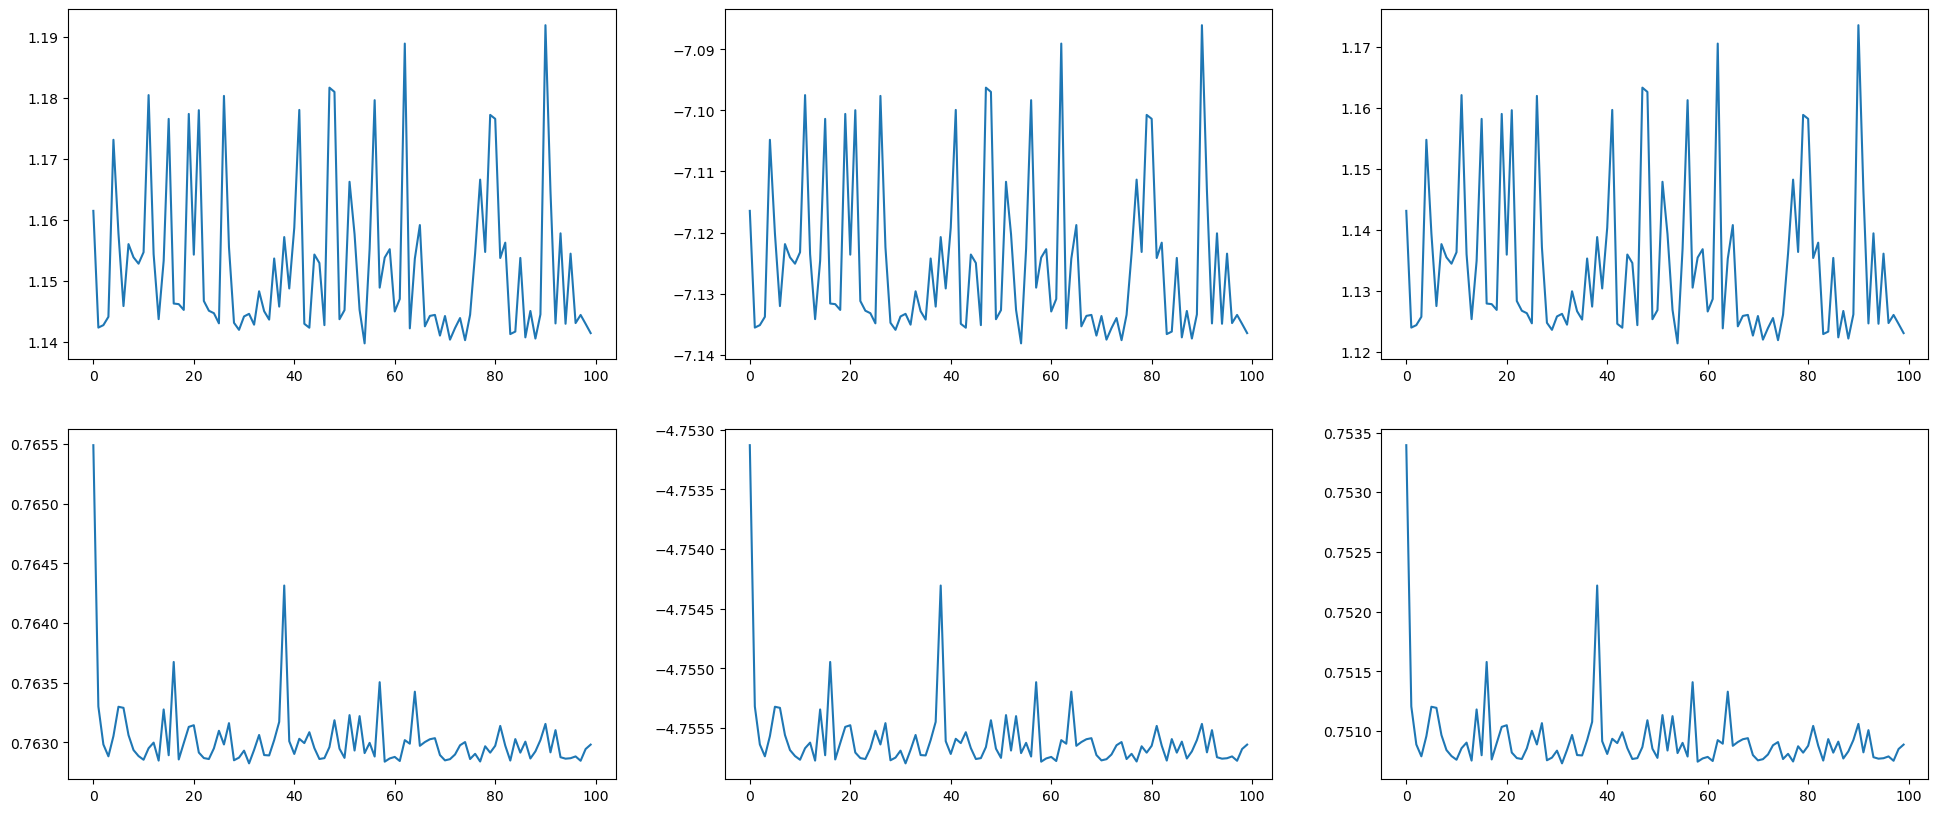

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 10))
plt.subplot(2, 3, 1)
plt.plot(epoch_pred_loss_list[0])
plt.subplot(2, 3, 2)
plt.plot(epoch_enc_id_loss_list[0])
plt.subplot(2, 3, 3)
plt.plot(epoch_clus_loss_list[0])
plt.subplot(2, 3, 4)
plt.plot(epoch_pred_loss_list[1])
plt.subplot(2, 3, 5)
plt.plot(epoch_enc_id_loss_list[1])
plt.subplot(2, 3, 6)
plt.plot(epoch_clus_loss_list[1])
plt.show()

In [14]:
from sklearn.metrics import roc_auc_score

real, preds = [], []
with torch.no_grad():
    for _, (x, y) in enumerate(test_loader):
        y_pred, _ = model.forward_pass(x)
        preds.extend(list(y_pred.cpu().detach().numpy()))
        real.extend(list(y.cpu().detach().numpy()))

roc_auc_score(real, preds)

0.5038930382896715

In [23]:
SEED = 12345
torch.random.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

torch.randn((1, 5))

tensor([[ 1.4271, -1.8701, -1.1962, -2.0440, -0.4560]])

In [95]:
SEED = 12345
torch.random.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = nn.Sequential(
    nn.Linear(1, 1),
    nn.Sigmoid(),
    nn.Linear(1, 1)
)

criterion = nn.MSELoss()
x = torch.randn(1, 1)
target = torch.ones(1, 1)

model.zero_grad()
optim = torch.optim.Adam(model.parameters(), lr=0.1)
output = model(x)
loss = criterion(output, target)
loss.backward()
optim.step()

lin1_grad_reg = model[0].weight.grad.clone()
lin2_grad_reg = model[2].weight.grad.clone()
print('No regularization')
print('Grad lin1: {}'.format(lin1_grad_reg))
print('Grad lin2: {}'.format(lin2_grad_reg))

model.zero_grad()
optim = torch.optim.Adam(model.parameters(), lr=0.1)
output = model(x)
loss = criterion(output, target)
loss.backward()
optim.step()

lin1_grad_reg = model[0].weight.grad.clone()
lin2_grad_reg = model[2].weight.grad.clone()
print('No regularization')
print('Grad lin1: {}'.format(lin1_grad_reg))
print('Grad lin2: {}'.format(lin2_grad_reg))

model.zero_grad()
output = model(x)
loss = criterion(output, target)
para = []
for parameter in model.parameters():
    para.append(parameter.view(-1))
parameters = torch.cat(para)
loss2 = 1e-6 * torch.abs(parameters).sum() + 1e-6 * torch.square(parameters).sum()
# loss2 = torch.norm(model[0].weight)
loss.backward(retain_graph=True)
loss2.backward()
optim.step()

lin1_grad_reg = model[0].weight.grad.clone()
lin2_grad_reg = model[2].weight.grad.clone()
print('No regularization')
print('Grad lin1: {}'.format(lin1_grad_reg))
print('Grad lin2: {}'.format(lin2_grad_reg))

No regularization
Grad lin1: tensor([[0.3859]])
Grad lin2: tensor([[-0.5490]])
No regularization
Grad lin1: tensor([[0.3107]])
Grad lin2: tensor([[-0.4409]])
No regularization
Grad lin1: tensor([[0.1926]])
Grad lin2: tensor([[-0.2784]])


In [96]:
loss2

tensor(5.9494e-06, grad_fn=<AddBackward0>)